In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.max_rows = 10

## Random Forest
Random Forest is an ensemble learning method in machine learning that combines multiple decision trees to make predictions. It is a type of decision tree algorithm that builds multiple trees and aggregates the votes from different trees to make a final prediction.

Potential Applications:
1) Sales forecasting
2) Customer churn prediction
3) Fraud detection
4) Stock market prediction
5) .. many more! Endless possibilities


## This notebook will focus on 2 things:
1) Preparing real data from the NBA to be used in a Random Forest Model.
2) Applying a Random Forest Model on NBA data to predict future player performance.

We will be using **Random Forest Regressor** for our analysis. This algorithm is used for regression tasks where the goal is to predict a continious-values output. This is opposed to **Random Forest Classifier** which is used for classification tasks used for predicting categorical outputs.

Please skip to the 2nd step if you are interested in seeing the model!

### Initial Data Assessment & Preparation for Modeling

In [2]:
data = pd.read_csv("nbadata_all_seasons.csv")
data.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Dennis Rodman,CHI,36.0,198.12,99.790240,Southeastern Oklahoma State,USA,1986,2,...,5.7,16.1,3.1,16.1,0.186,0.323,0.100,0.479,0.113,1996-97
1,1,Dwayne Schintzius,LAC,28.0,215.90,117.933920,Florida,USA,1990,1,...,2.3,1.5,0.3,12.3,0.078,0.151,0.175,0.430,0.048,1996-97
2,2,Earl Cureton,TOR,39.0,205.74,95.254320,Detroit Mercy,USA,1979,3,...,0.8,1.0,0.4,-2.1,0.105,0.102,0.103,0.376,0.148,1996-97
3,3,Ed O'Bannon,DAL,24.0,203.20,100.697424,UCLA,USA,1995,1,...,3.7,2.3,0.6,-8.7,0.060,0.149,0.167,0.399,0.077,1996-97
4,4,Ed Pinckney,MIA,34.0,205.74,108.862080,Villanova,USA,1985,1,...,2.4,2.4,0.2,-11.2,0.109,0.179,0.127,0.611,0.040,1996-97


In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         12305 non-null  int64  
 1   player_name        12305 non-null  object 
 2   team_abbreviation  12305 non-null  object 
 3   age                12305 non-null  float64
 4   player_height      12305 non-null  float64
 5   player_weight      12305 non-null  float64
 6   college            12305 non-null  object 
 7   country            12305 non-null  object 
 8   draft_year         12305 non-null  object 
 9   draft_round        12305 non-null  object 
 10  draft_number       12305 non-null  object 
 11  gp                 12305 non-null  int64  
 12  pts                12305 non-null  float64
 13  reb                12305 non-null  float64
 14  ast                12305 non-null  float64
 15  net_rating         12305 non-null  float64
 16  oreb_pct           123

A quick review of the dataframe and column types gives us good info to start with:
- Each row represents a player's performance for a given year accompanied by general demographic information on that player. This means that players who have played multiple seasons will have multiple rows of data.
- The first unnamed column is simply a count of the row which can be dropped.
- There are numerous categorical variables (dtype: object), some of which may need to be converted to numeric data before analysis. This includes the date columns (season, draft_year, ..).
- We don't have any missing values in the data (this is good!).

### Clarifying What Question we Want to Solve
Now that we understand our dataset a bit better, it is essential to clarify what question we are trying to solve. The same dataset can be used in many different ways, all of which will require a unique approach to data cleaning and model creation. For example, in this context of the NBA, we can use our dataset to solve for several different questions and important to different stakeholders:
- Scout: how many points per game will potential scouts score if we input information on their demographics and past performance?
    - This question focuses a lot more on identifying the important features at the college level that translate into success in the NBA. 
    - We do not necessarily care about individual NBA player history here (e.g., we do not care how much LeBron scored in year 4 vs. year 5).
- Coach: how many points per game will my current players score next season?
    - This question focuses a lot more on current player performance predicted by previous season performance.
    - We do care about individual NBA player history here (e.g., when predicting LeBron's points per game for next season, we would want to factor in his performance in previous years).

Note that the above are just a few quick examples and may not be perfect. There is a lot that goes into identifying which question one is trying to solve for which can get very complex. But remember: the clearer the question at the start = the clearer our answer!

**Our Question**: how many points per game are current players expected to score next season given certain demographic and past performance data?
- We will use data from a given year to predict performance for the following year. 

### Data Preparation
Let's start by dropping the first column and quickly converting the season column to a numeric value. Given this column is in "####-##" format, we will retain the first 4 numbers as the season for consistency. For example, 1996-97 will convert to 1996.

In [4]:
data = data.drop(columns = 'Unnamed: 0', axis=1)

data['season'] = pd.to_numeric(data['season'].str[:4])

print('Season datatype:', data['season'].dtype)

Season datatype: int64


Next, let's visualize the number of seasons a player has played

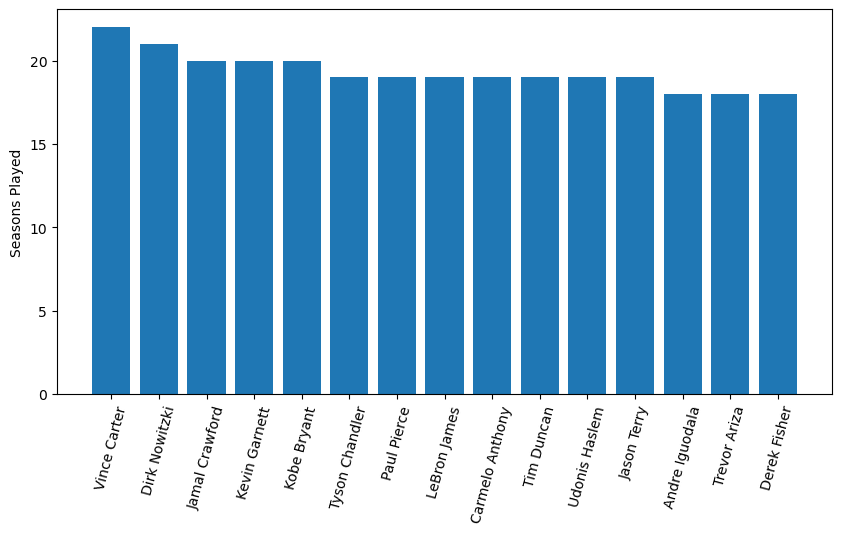

In [5]:
grouped = data.groupby('player_name').size().sort_values(ascending = False)
top10 = grouped.head(15)
plt.figure(figsize = (10,5))
plt.bar(top10.index,top10)
plt.ylabel('Seasons Played')
plt.xticks(top10.index, rotation=75)    

plt.show()

# top10.plot(kind='bar')

Great, now we can pull histograms to show the distribution of our major numerical variables below

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12305 non-null  object 
 1   team_abbreviation  12305 non-null  object 
 2   age                12305 non-null  float64
 3   player_height      12305 non-null  float64
 4   player_weight      12305 non-null  float64
 5   college            12305 non-null  object 
 6   country            12305 non-null  object 
 7   draft_year         12305 non-null  object 
 8   draft_round        12305 non-null  object 
 9   draft_number       12305 non-null  object 
 10  gp                 12305 non-null  int64  
 11  pts                12305 non-null  float64
 12  reb                12305 non-null  float64
 13  ast                12305 non-null  float64
 14  net_rating         12305 non-null  float64
 15  oreb_pct           12305 non-null  float64
 16  dreb_pct           123

Now let us us **convert our categorical variables into numeric values**. We will keep a mapping between our original categorical variable values and the new values to be referenced later. 

*Note that while it is preferred to one-hot encode categorical variables, we have opted to convert these to numeric values instead due to the number of possibilities. With hundreds of unique players, this can cause computational and memory issues.*

In [7]:
#Identify a list of categorical variables
cat = (data.dtypes == 'object')
object_columns = list(cat[cat].index)
print('Categorical variables:', object_columns, '\n')

#We can use LabelEncoder from SK Learn to 
#encode categorical variables as numeric values

# Create a dictionary to store the LabelEncoder instances for each object type column
encoders = {}

# Iterate over each object type column in the dataframe
for col in data.columns:
    if data[col].dtype == "object":
        # Initialize a LabelEncoder instance for the column
        le = LabelEncoder()
        # Fit and transform the column to convert object type to numeric values
        data[col] = le.fit_transform(data[col])
        # Store the LabelEncoder instance in the dictionary
        encoders[col] = le

data.info()

Categorical variables: ['player_name', 'team_abbreviation', 'college', 'country', 'draft_year', 'draft_round', 'draft_number'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12305 non-null  int32  
 1   team_abbreviation  12305 non-null  int32  
 2   age                12305 non-null  float64
 3   player_height      12305 non-null  float64
 4   player_weight      12305 non-null  float64
 5   college            12305 non-null  int32  
 6   country            12305 non-null  int32  
 7   draft_year         12305 non-null  int32  
 8   draft_round        12305 non-null  int32  
 9   draft_number       12305 non-null  int32  
 10  gp                 12305 non-null  int64  
 11  pts                12305 non-null  float64
 12  reb                12305 non-null  float64
 13  ast                12305 non-null  fl

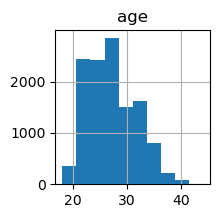

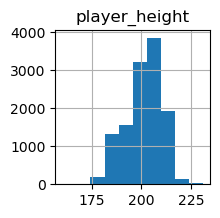

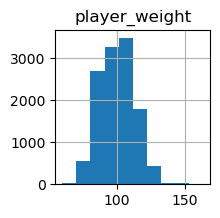

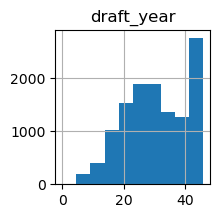

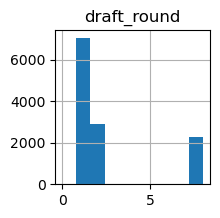

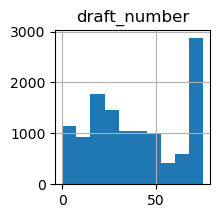

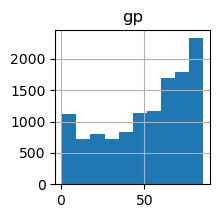

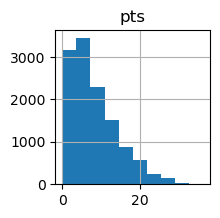

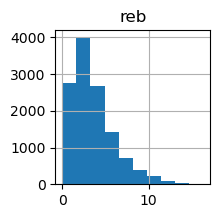

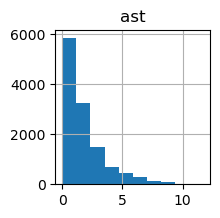

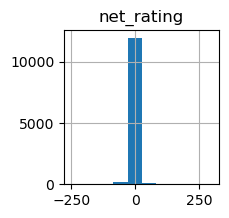

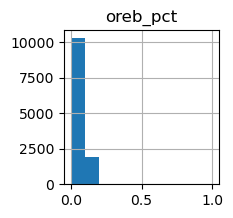

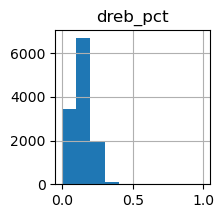

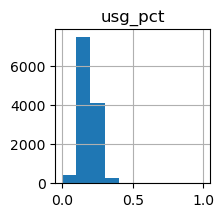

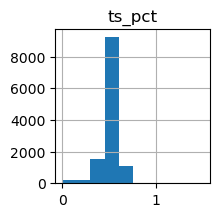

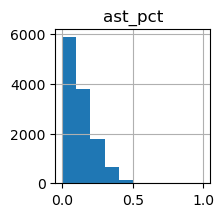

In [8]:
data_dist = data.drop(columns = ['player_name', 'team_abbreviation', 'college', 'country', 'season'])

for column in data_dist:
    plt.figure(figsize = (2,2))
    data_dist[column].hist()
    plt.title(column)
    plt.show()

The data is distributed as expected. Player demographics are more or less normally distributed while performance variables (points, assists, etc.) are all skewed to the right, indicating there is a large number of average players and very few great players. Additionally, this confirms that there is likely a minimum threshold of performing ability required that majority of the players possess, with a few number of high-performing players. The relative metric of net rating is normally distributed as it calculates player performance relative to other players.

**Scaling our data**. It can be helpful to standardize and normalize our data in order to prevent bias towards certain variables. Random Forest Models are quite robust and often do not necessitate this so we will skip this for now, but if we want to come back and scale our data that can be done as follows:

In [9]:
#Standardization - commenting out for now.

# columns = ['player_name', 'team_abbreviation', 'age', 'player_height', 'player_weight', 'college', 'country', 'draft_year', 'draft_round', 'draft_number', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct']

# def standardize_data(col):
#     return (col - col.mean()) / col.std()

# data[columns] = data[columns].apply(standardize_data)

# data.head()

Keeping in mind that we want to use a given year's data to predict next year's performance, **we now need to shift our data one row down**. This will allow us to train our model to use each year's data to predict the following year's performance (points). 

We will shift all rows that are expected to change year-over-year and leave constant rows alone (e.g., player name, college, etc.).

In [10]:
#adding new columns to the data to show the previous year's data
cols_to_shift = ['age', 'player_height', 'player_weight','gp','pts','reb','ast','net_rating','oreb_pct','dreb_pct','usg_pct','ts_pct','ast_pct']
for col in cols_to_shift:
    data[col + "_prev"] = data.groupby("player_name")[col].shift(1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12305 entries, 0 to 12304
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         12305 non-null  int32  
 1   team_abbreviation   12305 non-null  int32  
 2   age                 12305 non-null  float64
 3   player_height       12305 non-null  float64
 4   player_weight       12305 non-null  float64
 5   college             12305 non-null  int32  
 6   country             12305 non-null  int32  
 7   draft_year          12305 non-null  int32  
 8   draft_round         12305 non-null  int32  
 9   draft_number        12305 non-null  int32  
 10  gp                  12305 non-null  int64  
 11  pts                 12305 non-null  float64
 12  reb                 12305 non-null  float64
 13  ast                 12305 non-null  float64
 14  net_rating          12305 non-null  float64
 15  oreb_pct            12305 non-null  float64
 16  dreb

One other step before moving onto model creation will be to drop any data from the 2021-2022 season. This is being done as we will later input the 2021-2022 season data in our Random Forest Model to make predictions and compare.

In [11]:
data_2021 = data.query('season == 2021')
data = data.query('season != 2021')

print("Last season for updated data:", data['season'].max())

Last season for updated data: 2020


The final step before creating our model is to drop any null values from our dataset. While the original dataset did not contain any null values, shifting our data by one year did lead to null values as the first year for each player didn't have any prior year to shift data from.

In [12]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9367 entries, 442 to 11699
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_name         9367 non-null   int32  
 1   team_abbreviation   9367 non-null   int32  
 2   age                 9367 non-null   float64
 3   player_height       9367 non-null   float64
 4   player_weight       9367 non-null   float64
 5   college             9367 non-null   int32  
 6   country             9367 non-null   int32  
 7   draft_year          9367 non-null   int32  
 8   draft_round         9367 non-null   int32  
 9   draft_number        9367 non-null   int32  
 10  gp                  9367 non-null   int64  
 11  pts                 9367 non-null   float64
 12  reb                 9367 non-null   float64
 13  ast                 9367 non-null   float64
 14  net_rating          9367 non-null   float64
 15  oreb_pct            9367 non-null   float64
 16  dre

### Random Forest Model
Great! Now that we have pre-processed our data, we can now move onto our next step: splitting the data into features (x) and target variables (y). 

We can start off simple by having our model predict the points a player scores.

In [13]:
#Drop all data from the current year from our features
columns_dropped = ['pts', 'age', 'gp', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season', 'player_height', 'player_weight']

#Creating anoter columns_dropped list as this will be useful for future cases
columns_dropped_fut = ['age', 'gp', 'reb', 'ast', 'net_rating', 'oreb_pct', 'dreb_pct', 'usg_pct', 'ts_pct', 'ast_pct', 'season', 'player_height', 'player_weight']

x = data.drop(columns = columns_dropped)
y = data['pts']

**Checking for Colinearity**
Collinearity occurs when two or more features are highly correlated with one another, meaning that they provide redundant information about the target variable. By checking for collinearity before training a random forest regression model, we can identify and remove highly correlated features, which can improve the interpretability and stability of the model. This can also help prevent overfitting, since removing highly correlated features can reduce the complexity of the model and prevent it from fitting the noise in the data.

There are different ways to check for colinearity. We will calculate the pairwise correlation matrix for this purpose.

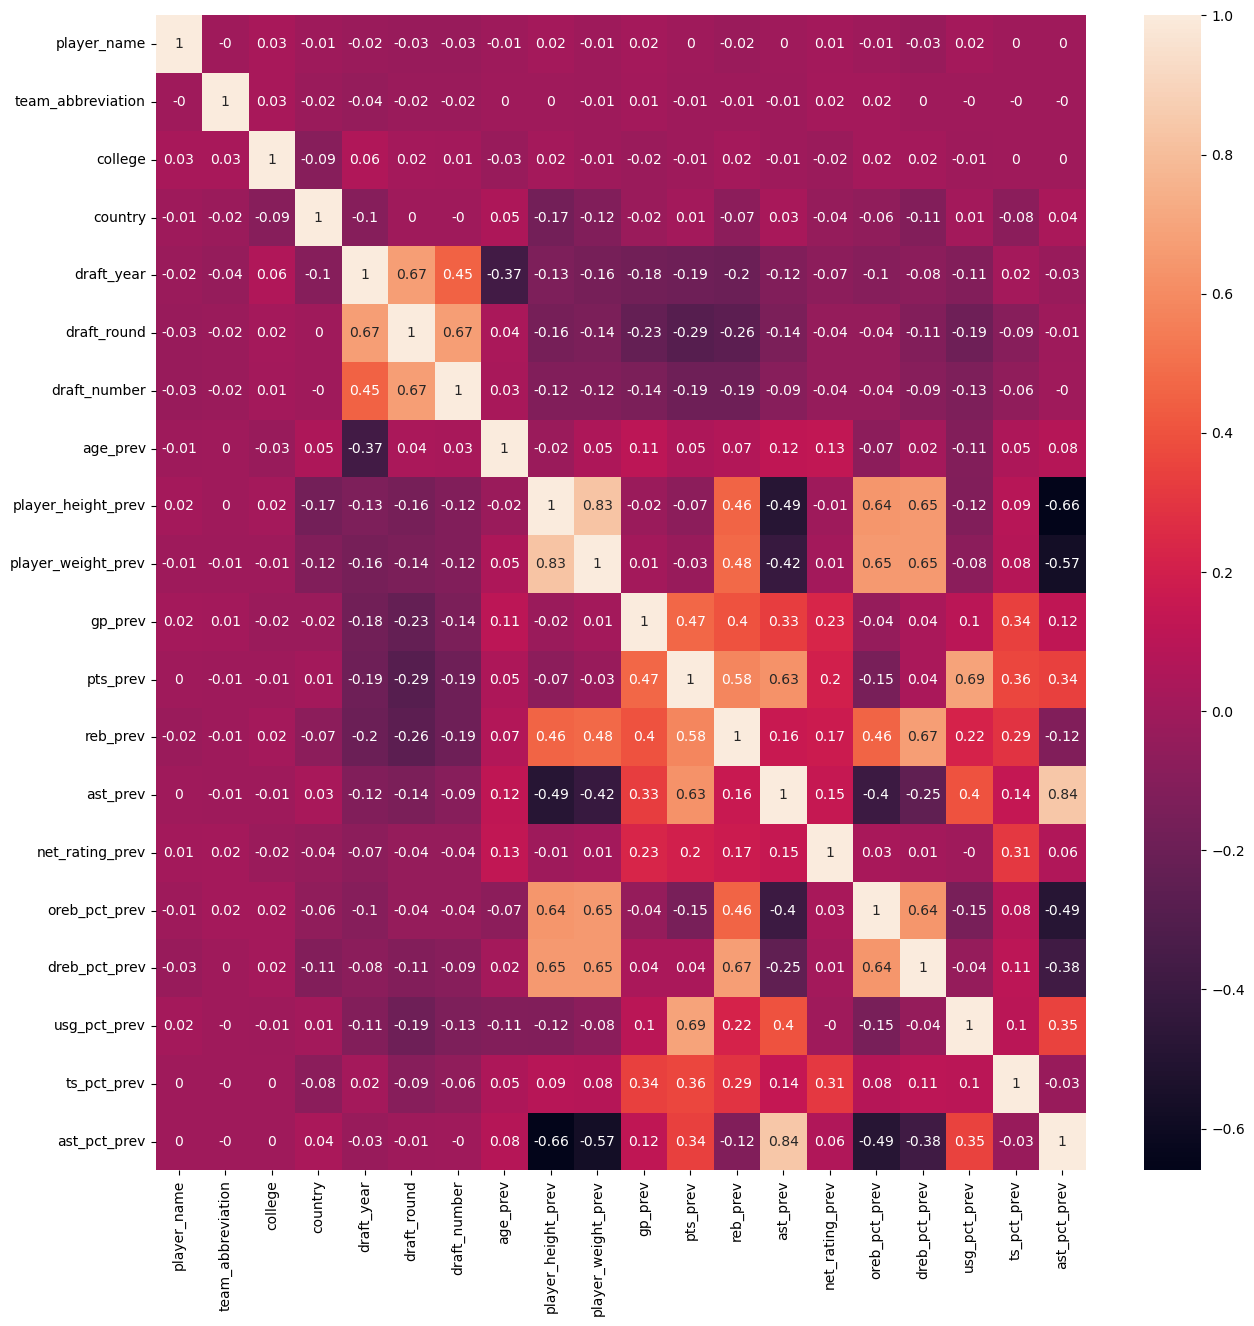

In [14]:
#Visualize the correlation matrix between the features used in our training model. We want to identify any features
#that have a high correlation with another and potentially remove it. 
correlation_matrix = x.corr()
correlation_matrix = correlation_matrix.round(2)

plt.figure(figsize = (15,15))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Let's remove features that are highly correlated with another feature:
- draft_round as it is highly correlated with draft_number (0.67)
- ast_prev as it is highly correlated with ast_pct_prev (0.84)

In [15]:
new_columns_dropped = ['draft_round', 'ast_prev']

#Save the list of dropped columns as this will be useful later
columns_dropped.extend(new_columns_dropped)
columns_dropped_fut.extend(new_columns_dropped)

#Drop the new columns identified above
x = x.drop(columns = new_columns_dropped)

Now we can split the data into training and test sets. This will later be used when evaluating the model's performance.

This is done by inputting our features (x) and target variables (y) resulting in 4 arrays: 

Additionally, there is test_size which determined the split between training and testing sets. In our instance, we are going with a value of 0.2 which means our data will be split 20%-80% between testing-training. 

The **choice of test_size** can affect the performance of the model. 
- A larger test_size means that more data will be set aside for testing, leaving less data for training. This can result in a less robust model, as the model has less data to learn from. 
- A smaller test_size means that more data is used for training, which can result in overfitting, where the model memorizes the training data instead of learning the underlying relationships.

The random_state is set to ensure we return the same split each time the code is re-run.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

Let us now **train the Random Forest Regression model** on the training data.

Here, we have to decide what to set the **n_estimators** parameter to. This is a parameter that controls the number of trees in the random forest. The tradeoff in setting n_estimators is between model accuracy and computational efficiency.
- A larger number of trees generally results in a more robust model as there are a higher number of trees, but also increases the computational time and memory required to fit the model.

In [17]:
regressor = RandomForestRegressor(n_estimators = 100 , random_state = 0)
regressor.fit(x_train, y_train)

RandomForestRegressor(random_state=0)

Having trained the model, now we can use this trained model to make predictions on the test data.

In [18]:
y_pred = regressor.predict(x_test)

### Evaluating Model Performance
Now that we have created our model and used it for predictions, we can now evaluate our model's performance. There are several ways to evaluate the performance of Random Forest Models:
1) **Mean Squared Error (MSE)** and **Root Mean Squared Error (RMSE)**: These metrics measure the average difference between the predicted values and the actual values. MSE is simply the average squared difference, while RMSE is the square root of the average squared difference. Lower values of MSE or RMSE indicate better model performance.

2) **Mean Absolute Error (MAE)**: This metric measures the average absolute difference between the predicted values and the actual values. Lower values of MAE indicate better model performance.


3) **R-squared**: This metric measures the proportion of variance in the target variable that is explained by the model. A value of 1.0 indicates a perfect fit, while a value of 0.0 indicates that the model explains none of the variance in the target variable.

4) **Confusion Matrix**: This is a table used to evaluate the performance of binary classification models. It shows the number of true positives, false positives, true negatives, and false negatives, and is used to calculate metrics such as accuracy, precision, recall, and F1 score.

5) **Receiver Operating Characteristic (ROC) Curve**: This is a graphical representation of the tradeoff between the true positive rate and false positive rate for binary classification models. The ROC curve is generated by plotting the true positive rate against the false positive rate for different threshold values. The area under the ROC curve (AUC) is used as a summary metric to evaluate the performance of the model.

6) **Precision-Recall Curve**: This is a graphical representation of the tradeoff between precision and recall for binary classification models. Precision is the number of true positive predictions divided by the number of true positive and false positive predictions, while recall is the number of true positive predictions divided by the number of true positive and false negative predictions.

We will use the first three (MSE, MAE, R-squared) to evaluate our model's performance.

In [19]:
#RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

#MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

#R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

RMSE: 2.9888230922981083
MAE: 2.3159028815368194
R-squared: 0.748497304286712


All three metrics point towards this model being an excellent predictor of points scored. Let us interpret each one by one:
- RMSE: 2.99. This value represents the average deviation of the predictions from the actual values in terms of the root mean squared difference. This is a relatively low value indicating the model is making good predictions on average.

- MAE: 2.32. This value represents the average deviation of the predictions from the actual values in terms of the absolute difference. This value, similar to RMSE, is also quite low, indicating good predictions.

- R-squared: 0.75. This value represents the proportion of the variance in the target variable that is explained by the features. This means that our model explaing 75% of the variance in points scored which is fairly high, also indicating towards a strong model.

**Feature Importance**
The feature importances in a random forest model represent the relative contribution of each feature to the model's predictions. These are calculated by measuring the average decrease in impurity that occurs when the feature is used to split the nodes in the trees of the forest.There are different methods used (Gini impurity, etc.). We will use SK Learn's feature_importances_ attribute that uses the **mean decrease impurity (MDI)** method.

In [20]:
#Calculating the feature importances and ranking them in descending order
importances = regressor.feature_importances_
feature_names = x_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
pd.options.display.max_rows = None
print(feature_importances)

               Feature  Importance
10            pts_prev    0.750554
6             age_prev    0.031823
12     net_rating_prev    0.024527
15        usg_pct_prev    0.019353
9              gp_prev    0.018632
16         ts_pct_prev    0.016985
0          player_name    0.016269
17        ast_pct_prev    0.016228
2              college    0.013561
1    team_abbreviation    0.012818
13       oreb_pct_prev    0.012543
4           draft_year    0.012012
14       dreb_pct_prev    0.012003
8   player_weight_prev    0.011657
5         draft_number    0.011613
11            reb_prev    0.009726
7   player_height_prev    0.006708
3              country    0.002989


As we can see, points scored in the previous season is the most important feature in our model by far. 

### Saving the model + Using it for new data
With a finished model that we are satisfied with, we can now deploy it to be used in the future!

We will deploy using the **pickle** library.

*Note: another option is to save the entire training pipeline using 'Pipeline' from SK Learn.*

1) First step is to save our model.

In [21]:
with open("points_predictor_rf.pkl", "wb") as file:
    pickle.dump(regressor, file)

2) Next we can load the model in a new environment where the model is to be deployed.

In [22]:
with open("points_predictor_rf.pkl", "rb") as file:
    regressor = pickle.load(file)

3) The third step is using the model to make predictions on new data.

Given we trained our model using data up to the 2020 season, we can now load data from the 2021-2022 season to be used in the model.

In [23]:
#Recall we saved the 2021-2022 season's data in data_2021
#Let's quickly run the data cleaning we did not conduct on this 
#data set but did on the original data dataframe.

#Reacall we created a future cases columnd dropped list that included 'pts'
data_2021_p = data_2021.drop(columns = columns_dropped_fut)

data_2021_p = data_2021_p.dropna()

# #Let's use our model to predict points scored by the player
y_pred = regressor.predict(data_2021_p.drop(columns = 'pts'))

Now we can evaluate our model's performance. One route is to recalculate the metrics discussed above (RMSE, MAE, R2). Another is to visually inspect via a scatter plot. We can plot our predicted values we our actual values. The hope is to see a strong linear relationship.

RMSE: 2.966447492593758
MAE: 2.3206631578947374
R-squared: 0.7902540019905961


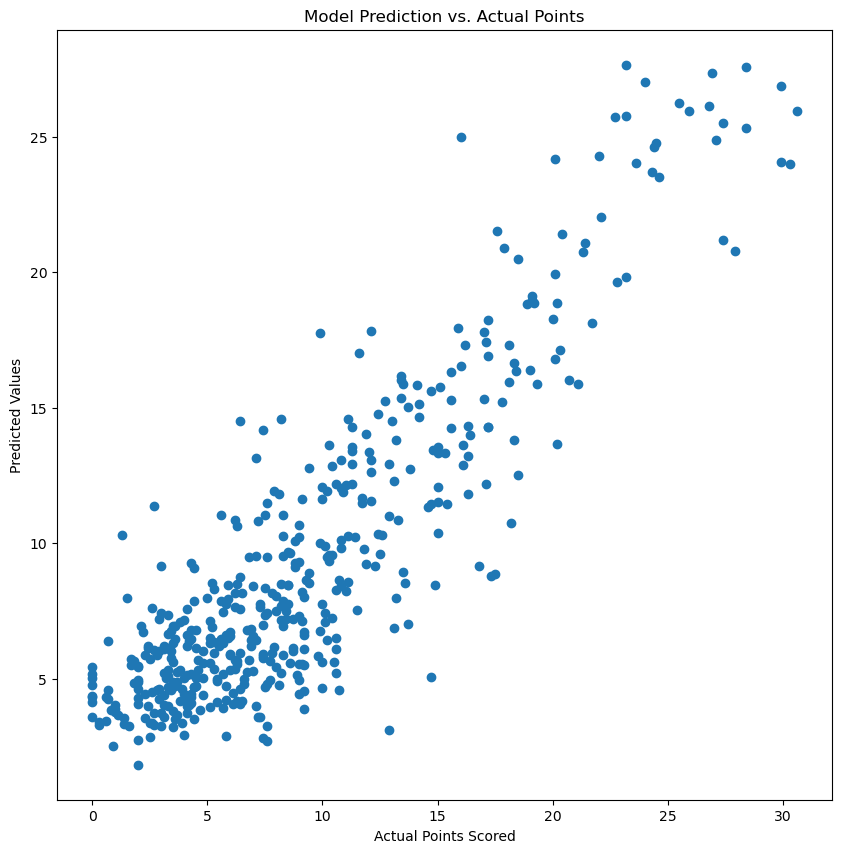

In [24]:
#Adding the predicted values to our data_2021 dataframe
data_2021_p['predicted'] = y_pred
points = ['pts', 'predicted']
data_2021_p[points]

rmse = np.sqrt(mean_squared_error(data_2021_p['pts'], data_2021_p['predicted']))
print("RMSE:", rmse)

#MAE
mae = mean_absolute_error(data_2021_p['pts'], data_2021_p['predicted'])
print("MAE:", mae)

#R-squared
r2 = r2_score(data_2021_p['pts'], data_2021_p['predicted'])
print("R-squared:", r2)

plt.figure(figsize = (10,10))
plt.scatter(x=data_2021_p['pts'], y=data_2021_p['predicted'])
plt.ylabel('Predicted Values')
plt.xlabel('Actual Points Scored')
plt.title('Model Prediction vs. Actual Points')
plt.show()

Here we see that our model did a solid job of predicting the points scored by nba players in the 2021-2022 season.

One thing to note is the **slight heteroskedasticity** seen in the plot. This is the inconsistent variance between actual points scored and predicted points scored as the points increase. 

In simple terms, what this means for our model is: it loses its accuracy as the number of points scored increases. We can quickly filter our data by predictions of greater than 15 points and evaluate the model's performance on that subset.

RMSE: 3.0381593902426327
MAE: 2.286922077922079
R-squared: 0.6268718541212275


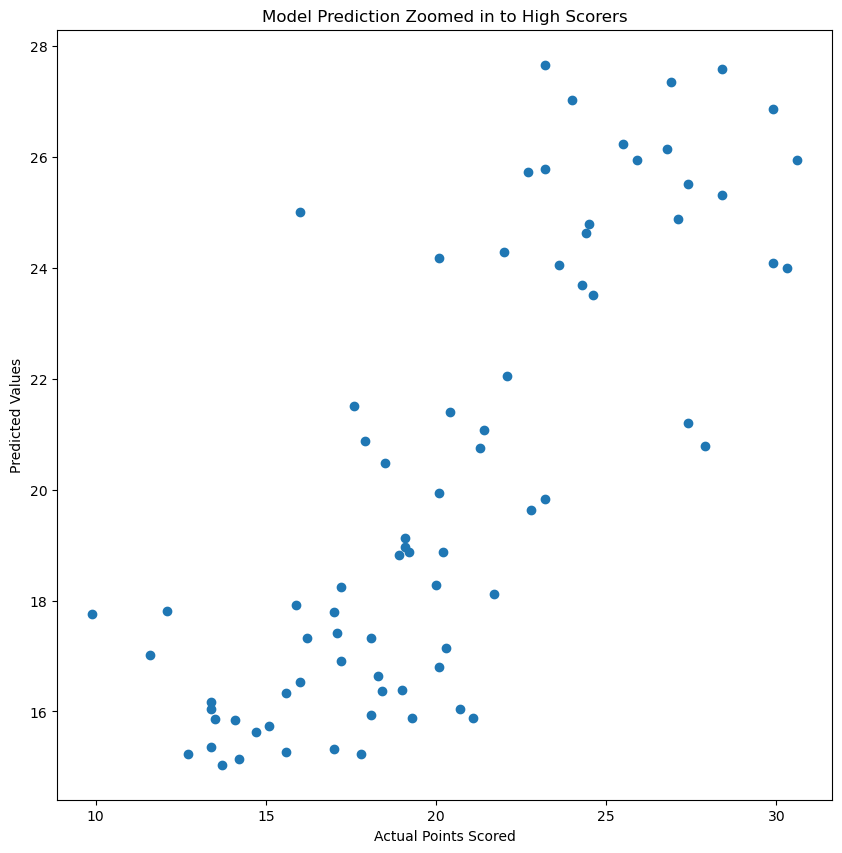

In [25]:
data_2021_hp = data_2021_p.query('predicted > 15')

rmse = np.sqrt(mean_squared_error(data_2021_hp['pts'], data_2021_hp['predicted']))
print("RMSE:", rmse)

#MAE
mae = mean_absolute_error(data_2021_hp['pts'], data_2021_hp['predicted'])
print("MAE:", mae)

#R-squared
r2 = r2_score(data_2021_hp['pts'], data_2021_hp['predicted'])
print("R-squared:", r2)

plt.figure(figsize = (10,10))
plt.scatter(x=data_2021_hp['pts'], y=data_2021_hp['predicted'])
plt.ylabel('Predicted Values')
plt.xlabel('Actual Points Scored')
plt.title('Model Prediction Zoomed in to High Scorers')
plt.show()

As expected, the model's performance is weaker when focused on players with a higher number of points scored. This makes sense as we have a lot less data to train the model with as points scored increases. Each team has several role players that score 5-10 points per game; but the entire NBA only has a handful of players consistently scoring 25+ points per game. Less data to train the model leads to less accuracy!

All is not gloom, however, as our model still performs somewhat well for this subset. While it is relatively worse, an r-squared of 0.63 still indicates that majority of the variance is explained by our model.

### Answering the original question: how many points per game will current players score next season?
Now that we have trained our model and have tested it twice, both with decent results, we can use it to predict next season's score for players on a given team.

Let us start by running our model on 2021's data. Note that in the previous example we ran the model on 2020's data to compare to 2021's point scored.

In [26]:
#Group the data by "player_name"
grouped = data_2021.groupby("player_name")

#Create a new row for each player. The idea here is we want a new "2022-2023" row that has data from 2021-2022 
#in the _prev columns and null values in the remaining columns. We will use this data from 2021-2022 to predict 
#their scoring in 2022-2023. 
for name, group in grouped:
    new_row = {col + "_prev": group[col].iloc[-1] for col in cols_to_shift}
    new_row['player_name'] = name
    new_row['season'] = 2022
    new_row['age'] = group['age'].iloc[-1]
    new_row['team_abbreviation'] = group['team_abbreviation'].iloc[-1]
    new_row['college'] = group['college'].iloc[-1]
    new_row['country'] = group['country'].iloc[-1]
    new_row['draft_year'] = group['draft_year'].iloc[-1]
    new_row['draft_round'] = group['draft_round'].iloc[-1]
    new_row['draft_number'] = group['draft_number'].iloc[-1]
    data_2021 = data_2021.append(new_row, ignore_index=True)

#Fill in the missing values for the current year's data
data_2021[cols_to_shift] = data_2021[cols_to_shift].fillna(value=np.nan)

#Create a new dataframe that only consists of latest data from the 2021-2022 season
data_2022 = data_2021.query('season == 2022')

#Drop all columns not showing data from 2021-2022. We will only use updated data from 2021-2022 season to predict 2022-2023 performance.
data_2022 = data_2022.drop(columns = columns_dropped_fut)

#Now we finally run our model on the data to predict points scored.
y_pred = regressor.predict(data_2022.drop(columns = 'pts'))

Our model has successfully run! But as you expected, we aren't able to do much with the results in terms of predicting specific player performance on a given team. This is because the values in the columns containing "player_name" and "team_abbreviation" were converted to numeric values before being used in our model. We can now convert these values back using the mapping we saved in the earlier step. 

In [27]:
#Convering float values back into int values for inverse transformation 
data_2022[['player_name', 'team_abbreviation', 'college', 'country', 'draft_year', 'draft_number']] = data_2022[['player_name', 'team_abbreviation', 'college', 'country', 'draft_year', 'draft_number']].astype(int)  

#Create a copy of the dataframe for the analysis
result_2022 = data_2022.copy()

#Iterate over each object type column in the analysis dataframe
for col in result_2022.columns:
    if data[col].dtype == "int":
        #Get the corresponding LabelEncoder instance from the dictionary
        le = encoders[col]
        #Use the inverse_transform method to revert the numeric values back to the original object type values
        result_2022[col] = le.inverse_transform(result_2022[col])

#Add predictions back to the results table so we can see which players are predicted to score how many points!
result_2022['predicted'] = y_pred

We are finally ready to review our results! Let's look at predicted values for points scored during the 2022-2023 season for players on the Lakers.  

              player_name team_abbreviation  predicted
628         Anthony Davis               LAL     21.323
634         Austin Reaves               LAL      7.534
636         Avery Bradley               LAL      4.845
677       Carmelo Anthony               LAL     10.701
706         D.J. Augustin               LAL      3.378
724       Darren Collison               LAL      2.784
773         Dwight Howard               LAL      3.936
877              Jay Huff               LAL      2.838
887        Jemerrio Jones               LAL      2.749
946         Kent Bazemore               LAL      3.314
979          LeBron James               LAL     28.128
993           Mac McClung               LAL      5.277
999            Malik Monk               LAL     13.267
1011          Mason Jones               LAL      7.147
1106    Russell Westbrook               LAL     14.629
1118      Sekou Doumbouya               LAL      9.202
1130      Stanley Johnson               LAL      5.144
1138  Tale

<function matplotlib.pyplot.show(close=None, block=None)>

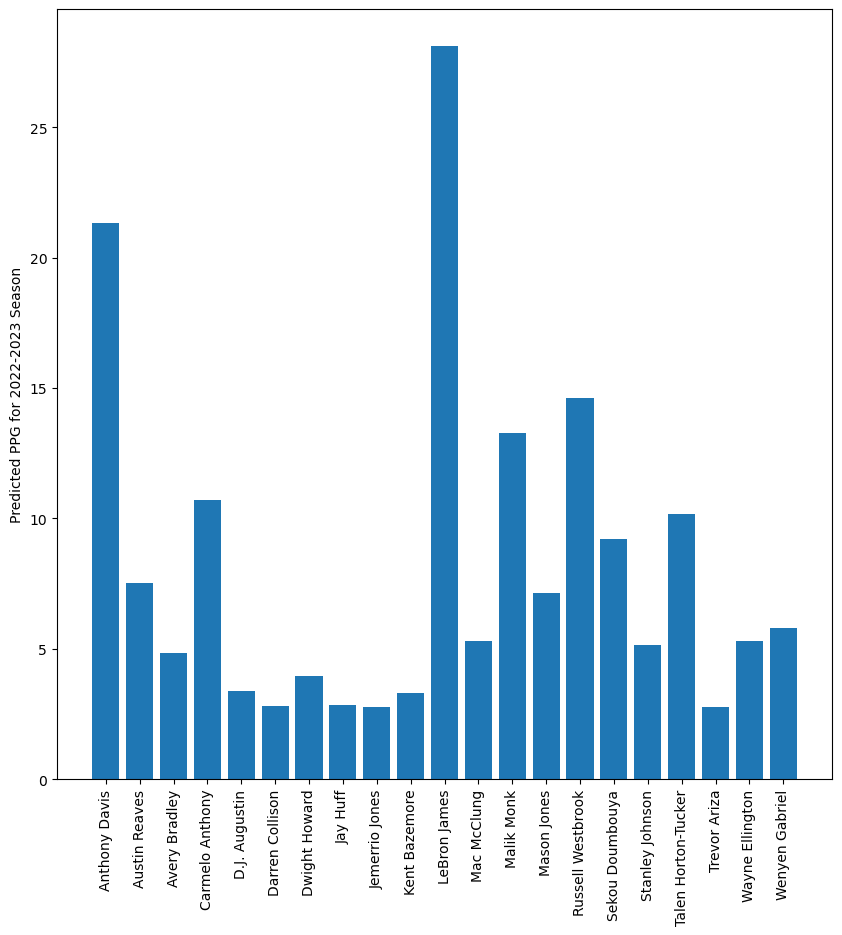

In [28]:
#Updating the max rows setting in order to see predictions for all players.
pd.options.display.max_rows = None
result_2022_LAL = result_2022[['player_name', 'team_abbreviation', 'predicted']].query('team_abbreviation == "LAL"')
print(result_2022_LAL)

#Updating the max rows setting back for future analyses
pd.options.display.max_rows = 10

plt.figure(figsize = (10,10))
plt.bar(result_2022_LAL['player_name'], result_2022_LAL['predicted'])
plt.ylabel('Predicted PPG for 2022-2023 Season')
plt.xticks(rotation=90)
plt.show

### All done!
There we have it folks! We have successfully predicted the points per game for NBA players during the 2022-2023 season. These predictions were made using the Random Forest Regressor machine learning model, an ensemble learning method that combines multiple decision trees to make predictions by aggregating the results of individual trees, creating a forest of trees that output the final prediction.

As you probably already gathered, we can re-create this model for any other metric including assists, rebounds, playing rating, shooting percentage, and more! Let's keep an eye out this season to see if these predictions end up close to reality.

*Note: this is one of many approaches that can be taken to solve this problem. We could have also utilized advanced time-series models to solve this problem such as ARIMA, Emponential Smoothing Models, and Long Short-Term Memory (LSTM). Those models would be well-suited to account for temoporal dependencies as well as sequential data. Perhaps we can use one of those for a future similar problem!*